# Pyspark & Astrophysical data: BINTABLE

Let's first play with Bintable. In this example, we load data from a FITS file containing RA/Dec cooordinates, and convert it to healpix index. We then perform neighbour search.

In [1]:
## Import SparkSession from Spark
from pyspark.sql import SparkSession

In [2]:
## Create a DataFrame from the HDU data of a FITS file
df = spark.read.format("fits").option("hdu", 1).load("../../src/test/resources/test_file.fits")

In [3]:
## Print the schema built from the header
## and show the first 5 rows.
df.printSchema()
df.show(5)

root
 |-- target: string (nullable = true)
 |-- RA: float (nullable = true)
 |-- Dec: double (nullable = true)
 |-- Index: long (nullable = true)
 |-- RunId: integer (nullable = true)

+----------+---------+--------------------+-----+-----+
|    target|       RA|                 Dec|Index|RunId|
+----------+---------+--------------------+-----+-----+
|NGC0000000| 3.448297| -0.3387486324784641|    0|    1|
|NGC0000001| 4.493667| -1.4414990980543227|    1|    1|
|NGC0000002| 3.787274|  1.3298379564211742|    2|    1|
|NGC0000003| 3.423602|-0.29457151504987844|    3|    1|
|NGC0000004|2.6619017|  1.3957536426732444|    4|    1|
+----------+---------+--------------------+-----+-----+
only showing top 5 rows



# Map visualisation

In [4]:
## Let's convert our data into healpix index
import healpy as hp
import numpy as np

def dec2theta(dec):
    """
    Convert Declination into Theta
    
    Parameters
    ----------
    dec : Double
        Declination angle (in radian)
        
    Returns
    ----------
    theta : Double
        Theta angle (in radian)
    """
    return np.pi / 2. - dec

def ra2phi(ra):
    """
    Convert RA into Phi
    
    Parameters
    ----------
    ra : Double
        Right Ascension angle (in radian)
        
    Returns
    ----------
    phi : Double
        Phi angle (in radian)
    """
    return ra

nside = 16

## Pyspark DataFrames do not have "map" method - so you need
## to convert it to RDD first.
rdd = df.select(df["RA"], df["Dec"])\
    .rdd\
    .map(lambda x: hp.ang2pix(nside, dec2theta(x[1]), ra2phi(x[0])))
    
## Show the first 10 pixels
rdd.take(10)

[2051, 3056, 33, 1987, 30, 521, 48, 259, 862, 3038]

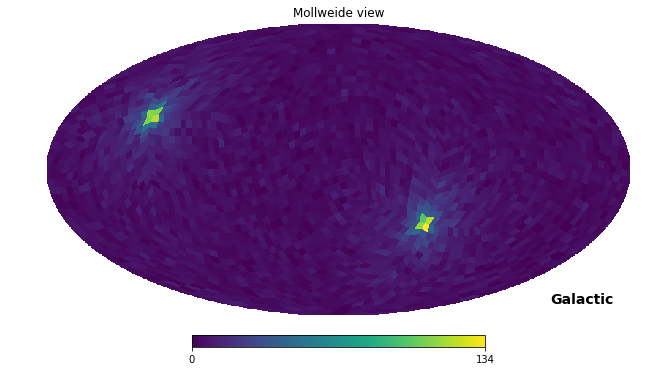

In [5]:
## Let's gather the result per-pixel (hit count), and plot the resulting map
import matplotlib.pyplot as pl

hitcount = rdd.map(lambda x: (x, 1))
myPartialMap = hitcount.countByKey()

myMap = np.zeros(12 * nside**2)
myMap[list(myPartialMap.keys())] = list(myPartialMap.values())

## Fake rotation of the coordinate system of the map for visu
hp.mollview(myMap, coord="CG")
pl.show()

# Neighbour search

23 distinct neighbours found


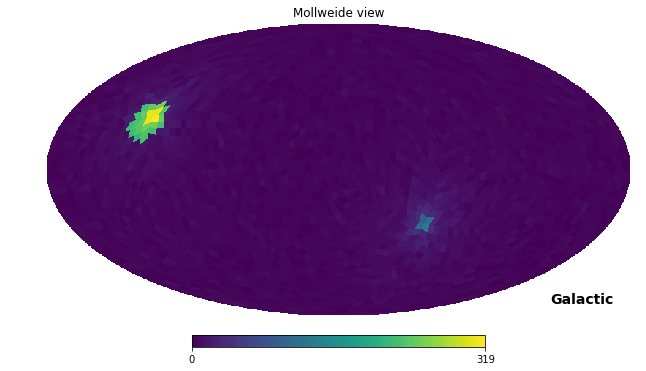

In [6]:
## Let's now search for neighbours around a point of interest
point = hp.pix2vec(nside, 0)
radius = 10 * np.pi / 180

neighbours = rdd\
    .map(lambda x: (x, x in hp.query_disc(nside, point, radius)))\
    .filter(lambda x: x[1])\
    .map(lambda x: x[0])\
    .collect()

print("{} distinct neighbours found".format(len(np.unique(neighbours))))
## Visualise the result
## Fake rotation of the coordinate system of the map for visu
myMap[neighbours] += 200.
hp.mollview(myMap, coord="CG")
pl.show()